In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from PIL import Image  # For GIF creation
import os
import warnings

import numpy as np
import pandas as pd
import skimage
import torch

import neuralpredictors

warnings.filterwarnings("ignore")

from nnfabrik.builder import get_data, get_model, get_trainer


In [20]:
redaout_keys = ['23964-4-22','21067-10-18','22846-10-16','23343-5-17','26872-17-20','23656-14-22','27204-5-13']
cell_motor_coordinates_list = []
for k in redaout_keys:
    cell_motor_coordinates = np.load(f'/usr/users/agecker/datasets/sensorium_2022_pictures/real_dataset/static{k}-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/meta/neurons/cell_motor_coordinates.npy')
    cell_motor_coordinates_list.append(cell_motor_coordinates)
cell_motor_coordinates_mice = np.vstack(cell_motor_coordinates_list)

In [21]:
starting_epcoch = 10
multiplier = 4000.0
exponent=2
clusters=19
path_ending = f'KL_uniform_exp_{exponent}_cluster_{clusters}_mult_{multiplier}_reg_adlognorm_se{starting_epcoch}'
path_ending

'KL_uniform_exp_2_cluster_19_mult_4000.0_reg_adlognorm_se10'

Euclidian distance of the cluster centers and the 0 vector [ 1.0674978  1.0675433  1.0675304 29.989285   1.282034  25.544489
  1.2819867  1.1257228  1.2819932 29.774359   1.0675472 25.301773
  1.1257297  1.282152   1.0674771  1.2820977  1.125717   1.282148
 30.269415 ]


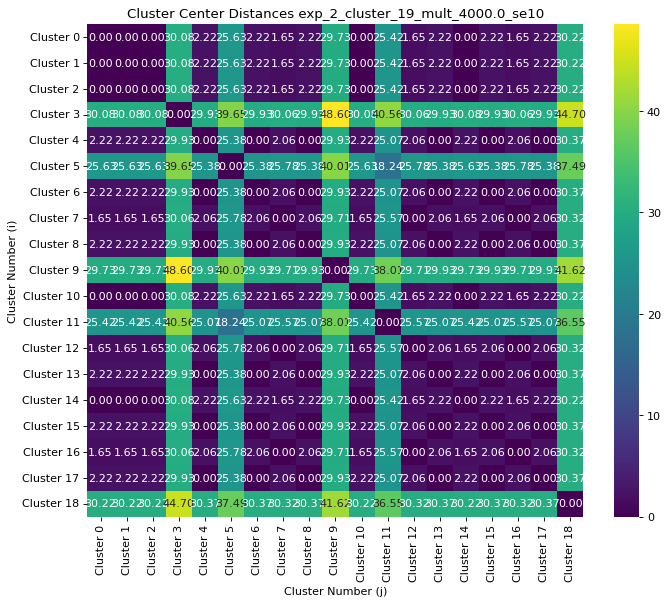

In [22]:
cluster_centers_epochs = np.load(f'/user/ninasophie.nellen/sensorium/tests/cluster_centers/cluster_centers_{path_ending}.npy')
#cluster_centers_epochs = np.load(f"/user/ninasophie.nellen/sensorium/tests/cluster_centers/cluster_centers_se{dec_starting_epcoch}_we{dec_wamup_epcoh}.npy")
#print(cluster_centers_epochs.shape)
cluster_numbers = cluster_centers_epochs.shape[1]
cluster_centers=cluster_centers_epochs[-1]
euclidian_distance = np.linalg.norm(cluster_centers,axis=1)
#print(cluster_centers)
print('Euclidian distance of the cluster centers and the 0 vector', euclidian_distance)

distance_matrix = np.zeros((cluster_numbers, cluster_numbers))

for i in range(cluster_numbers):
    for j in range(cluster_numbers):
        if i != j:
            distance_matrix[i, j] = np.linalg.norm(cluster_centers[i] - cluster_centers[j])  # Euclidean distance


# Step 2: Create a DataFrame to make it more interpretable
distance_df = pd.DataFrame(distance_matrix, 
                           index=[f'Cluster {i}' for i in range(cluster_numbers)], 
                           columns=[f'Cluster {j}' for j in range(cluster_numbers)])

# Step 3: Plot the distance table as a heatmap
plt.figure(figsize=(10, 8), dpi=80)
sns.heatmap(distance_df, annot=True, fmt=".2f", cmap="viridis", cbar=True)

plt.title(f'Cluster Center Distances exp_{exponent}_cluster_{clusters}_mult_{multiplier}_se{starting_epcoch}')
plt.xlabel('Cluster Number (j)')
plt.ylabel('Cluster Number (i)')

# Save the heatmap plot as a PNG file
plt.savefig(f'plots/cluster_center_distances_heatmap_{path_ending}.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

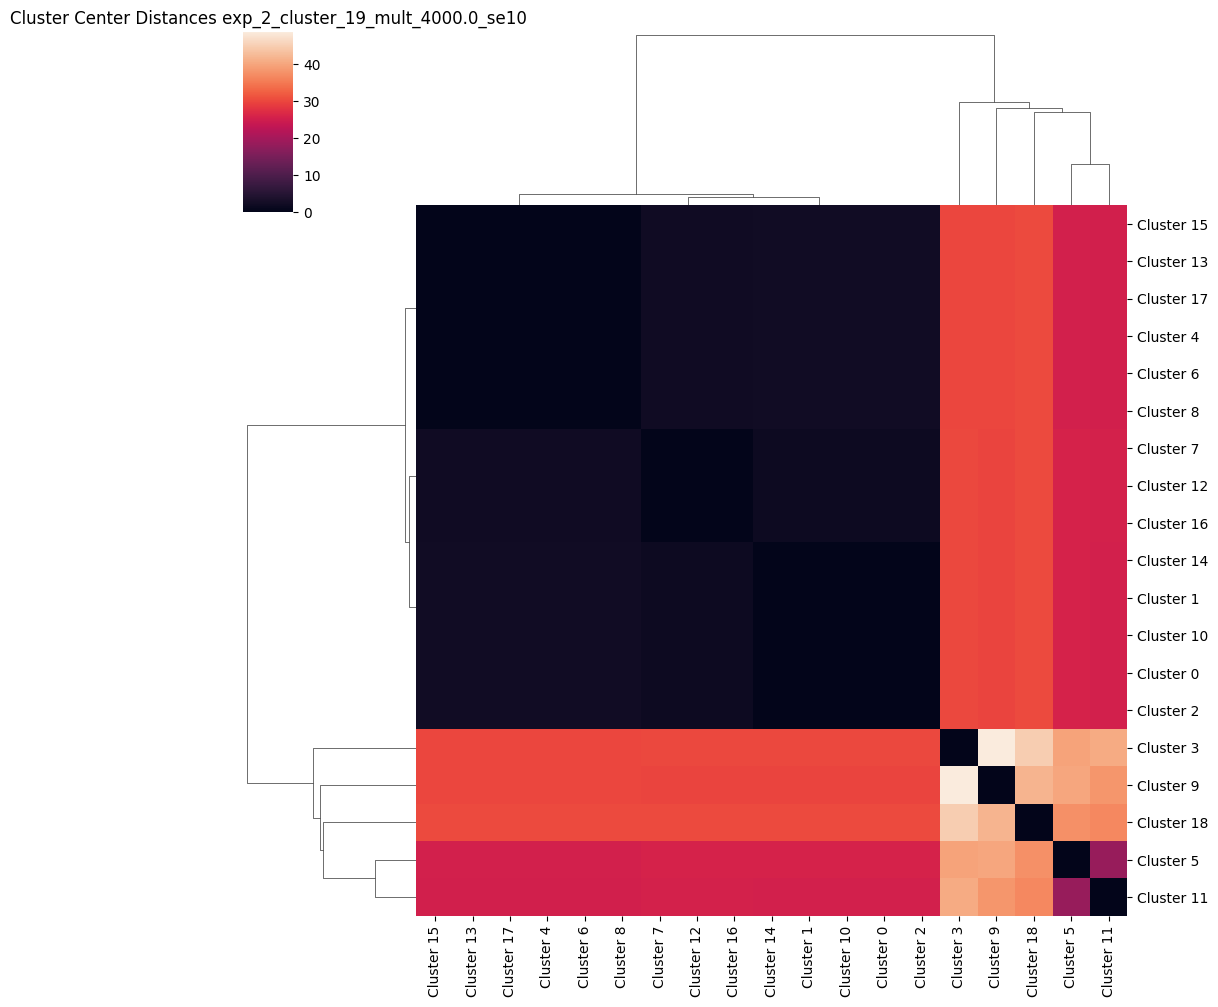

In [23]:
#distance_df = distance_df.set_index('model')
 
# Default plot
sns.clustermap(distance_df)
plt.title(f'Cluster Center Distances exp_{exponent}_cluster_{clusters}_mult_{multiplier}_se{starting_epcoch}')

# Save the heatmap plot as a PNG file
plt.savefig(f'plots/cluster_center_distances_clustermap_{path_ending}.png', dpi=300, bbox_inches='tight')

# Show the graph
plt.show()

In [24]:
predictions = torch.load(f'/user/ninasophie.nellen/sensorium/tests/predictions/predictions_dec_{path_ending}.pt').cpu().numpy()
#torch.load(f"/user/ninasophie.nellen/sensorium/tests/predictions/predictions_dec_se{dec_starting_epcoch}_we{dec_wamup_epcoh}.pt").cpu().numpy()
print(predictions.shape)
unique_values, counts = np.unique(predictions, return_counts=True)
print(f"There are {counts} values of cluster {unique_values}")
for value, count in zip(unique_values, counts):
    print(f"Cluster {value} has {count} entries")

predictions    

(54569,)
There are [ 6551   514  1100   687  3113  7343  3060   477  3100   340 17025   269
 10232   758] values of cluster [ 0  1  2  4  6  7  8 10 12 13 14 15 16 17]
Cluster 0 has 6551 entries
Cluster 1 has 514 entries
Cluster 2 has 1100 entries
Cluster 4 has 687 entries
Cluster 6 has 3113 entries
Cluster 7 has 7343 entries
Cluster 8 has 3060 entries
Cluster 10 has 477 entries
Cluster 12 has 3100 entries
Cluster 13 has 340 entries
Cluster 14 has 17025 entries
Cluster 15 has 269 entries
Cluster 16 has 10232 entries
Cluster 17 has 758 entries


array([ 1, 16, 14, ...,  0, 16, 17])

In [25]:
for i in range(cluster_numbers):
    for j in range(i,cluster_numbers):
        if i != j:
            print(distance_matrix[i, j] )
            if abs(distance_matrix[i, j] - 0.0) < 1e-3:
                predictions[predictions == j] = i  # Replace cluster j values with i

print("Updated Predictions:", predictions)
unique_values, counts = np.unique(predictions, return_counts=True)
print(f"There are {counts} values of cluster {unique_values}")
for value, count in zip(unique_values, counts):
    print(f"Cluster {value} has {count} entries")

predictions    

0.000964684528298676
0.0008452999754808843
30.082006454467773
2.2157084941864014
25.629920959472656
2.215646743774414
1.6521403789520264
2.215623378753662
29.725034713745117
0.0009326055296696723
25.41606903076172
1.6521068811416626
2.2158713340759277
0.0009704224648885429
2.215843439102173
1.6520841121673584
2.2158734798431396
30.221588134765625
0.0009036166011355817
30.081890106201172
2.2157809734344482
25.6298770904541
2.215719223022461
1.6521015167236328
2.215695858001709
29.725069046020508
0.000791224476415664
25.41607666015625
1.652068018913269
2.2159438133239746
0.000978096155449748
2.215916395187378
1.6520451307296753
2.2159459590911865
30.221595764160156
30.081939697265625
2.215742349624634
25.629894256591797
2.2156803607940674
1.652145504951477
2.2156569957733154
29.725011825561523
0.0008519762777723372
25.416051864624023
1.6521121263504028
2.21590518951416
0.0009488630457781255
2.2158775329589844
1.6520893573760986
2.215907096862793
30.22165298461914
29.927125930786133
39.65

array([ 0,  7,  0, ...,  0,  7, 13])

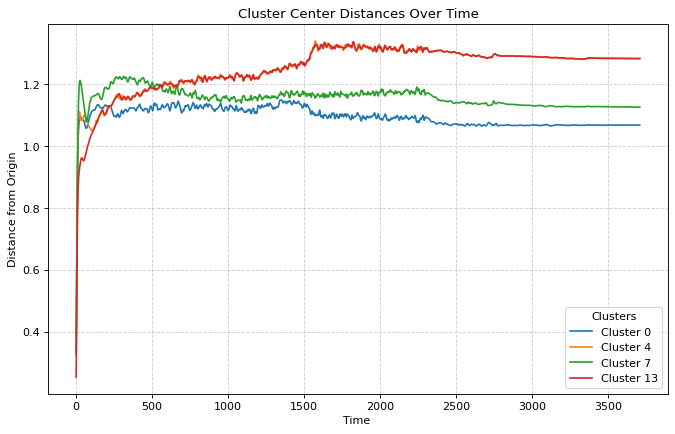

In [26]:
time = cluster_centers_epochs.shape[0]
cluster_centers_distances=np.zeros((time, cluster_numbers)) 

for batch in range(time):
    cluster_centers_distances[batch][:] = np.linalg.norm(cluster_centers_epochs[batch],axis=1)

# Plot the distances of the cluster centers over time
plt.figure(figsize=(10, 6), dpi=80)

for cluster_idx in range(cluster_numbers):
    if cluster_idx in unique_values:
        plt.plot(range(time), cluster_centers_distances[:, cluster_idx], label=f'Cluster {cluster_idx}')

plt.xlabel('Time ')
plt.ylabel('Distance from Origin')
plt.title('Cluster Center Distances Over Time')
plt.legend(title='Clusters', loc='lower right', frameon=True)
plt.grid(True, linestyle='--',alpha=0.6)

# Save the plot
plt.savefig(f'plots/cluster_center_distances_form_origin_{path_ending}.png', dpi=300, bbox_inches='tight')
plt.show()


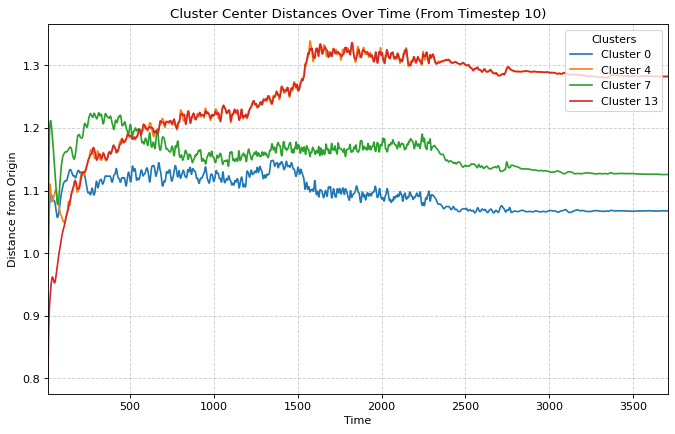

In [27]:
# Adjust the range of timesteps to start from 2
start_time = 10
time = cluster_centers_epochs.shape[0]
cluster_centers_distances = np.zeros((time, cluster_numbers))

# Compute distances
for batch in range(time):
    cluster_centers_distances[batch][:] = np.linalg.norm(cluster_centers_epochs[batch], axis=1)

# Plot the distances of the cluster centers over time
plt.figure(figsize=(10, 6), dpi=80)

for cluster_idx in range(cluster_numbers):
    if cluster_idx in unique_values:
        # Plot starting from timestep 2
        plt.plot(range(start_time, time), cluster_centers_distances[start_time:, cluster_idx], label=f'Cluster {cluster_idx}')

# Adjust x-axis limits to start from timestep 2
plt.xlim(start_time, time - 1)
plt.xlabel('Time')
plt.ylabel('Distance from Origin')
plt.title('Cluster Center Distances Over Time (From Timestep 10)')
plt.legend(title='Clusters', loc='upper right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)

# Save and show the plot
plt.savefig(f'plots/cluster_center_distances_from_timestep2_{path_ending}.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# loading the SENSORIUM+ dataset
pre = "/usr/users/agecker/datasets/sensorium_2022_pictures/real_dataset/"
filenames = [f"{pre}{i}/" for i in os.listdir(pre)]

dataset_fn = "sensorium.datasets.static_loaders"
dataset_config = {
    "paths": filenames,
    "normalize": True,
    "include_behavior": True,
    "include_eye_position": True,
    "batch_size": 128,
    "scale": 0.25,
}

dataloaders = get_data(dataset_fn, dataset_config)
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'stack': -1,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 10,
  'hidden_kern': 7,
  'hidden_channels': 128,
  'depth_separable': True,
  'grid_mean_predictor': {
    'type': 'cortex',
    'input_dimensions': 2,
    'hidden_layers': 1,
    'hidden_features': 30,
    'final_tanh': True
   },
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': True,
  'regularizer_type': 'adaptive_log_norm',
  #'feature_reg_weight': 10,
}
model = get_model(
    model_fn=model_fn,
    model_config=model_config,
    dataloaders=dataloaders,
    seed=42,
)


# Base the save path on the script's location
save_path = f'/user/ninasophie.nellen/sensorium/tests/model_checkpoints/sensorium_model_dec_{path_ending}.pth'
#save_path = f"/user/ninasophie.nellen/sensorium/tests/model_checkpoints/sensorium_model_dec_se{dec_starting_epcoch}_we{dec_wamup_epcoh}.pth"
model.load_state_dict(torch.load(save_path),strict=False)

<All keys matched successfully>

In [29]:
features_list = []  # List to store features
random_indices = []  # To store consistent indices
features_subset = []  # To store subsets of features
features_shape_previous = 0
i = 0

for k, readout in model.readout.items():
    # Extract features and their shape
    features = readout.features.cpu().detach().squeeze().T.numpy()
    features_list.append(features)  # Append the full features to the list
    print(f"Features for readout {k}: {features.shape}")
    if len(random_indices) <= i:
        # Generate random indices only for the first pass
        random_indices.append(np.random.choice(features.shape[0], size=2000, replace=False))
    
    # Select subset of features using consistent indices
    current_indices = random_indices[i]
    features_subset.append(features[current_indices, :])
    
    # Update predictions subset indices
    global_indices = current_indices + features_shape_previous
    features_shape_previous += features.shape[0]

    i += 1

# Combine random indices globally for predictions
random_indices_predicted = np.concatenate([indices + sum(len(f) for f in features_list[:i]) 
                                           for i, indices in enumerate(random_indices)])

#subset for all_center_coordinates that matches the random indices generated before
cell_motor_coordinates_mice_subset = cell_motor_coordinates_mice[random_indices_predicted]

# Create predictions_subset using the consistent indices
predictions_subset = predictions[random_indices_predicted]
print(predictions_subset.shape)

# Unique values and number of clusters
unique_values = np.unique(predictions_subset)
num_clusters = len(unique_values)  # Number of unique clusters

# Combine all subsets into a single array for t-SNE
combined_features = np.vstack(features_subset)
n = combined_features.shape[0]

Features for readout 23964-4-22: (8098, 128)
Features for readout 21067-10-18: (8372, 128)
Features for readout 22846-10-16: (7344, 128)
Features for readout 23343-5-17: (7334, 128)
Features for readout 26872-17-20: (7776, 128)
Features for readout 23656-14-22: (8107, 128)
Features for readout 27204-5-13: (7538, 128)
(14000,)


In [30]:
cell_motor_coordinates_mice_subset
# Calculate min and max values for each column

min_values = np.min(cell_motor_coordinates_mice_subset, axis=0)

max_values = np.max(cell_motor_coordinates_mice_subset, axis=0)



min_values, max_values

(array([-1209,  -464,   193]), array([  60, 1006,  263]))

## TSNE plot with colors according to cell_motor_coordinates_mice_subset

<Figure size 640x800 with 0 Axes>

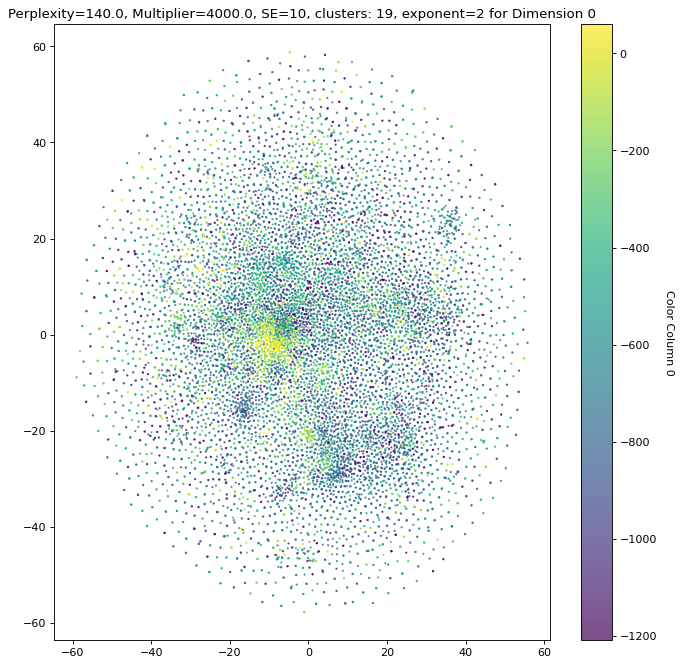

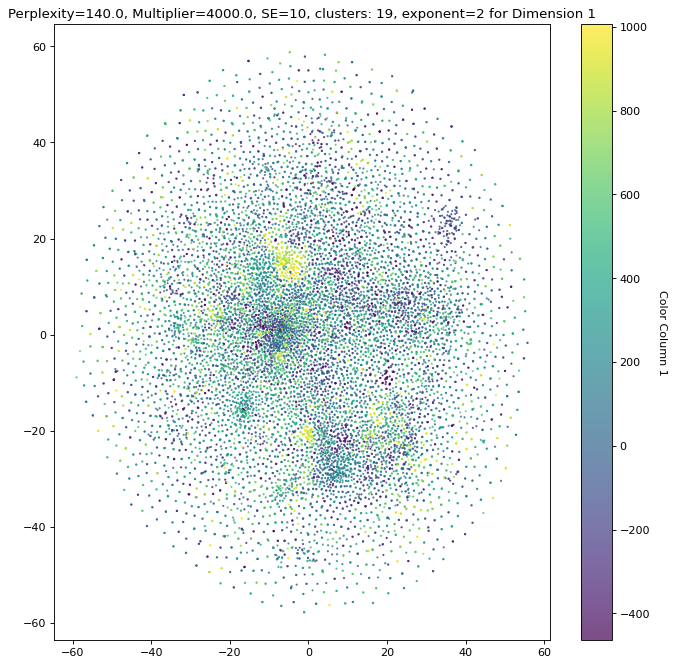

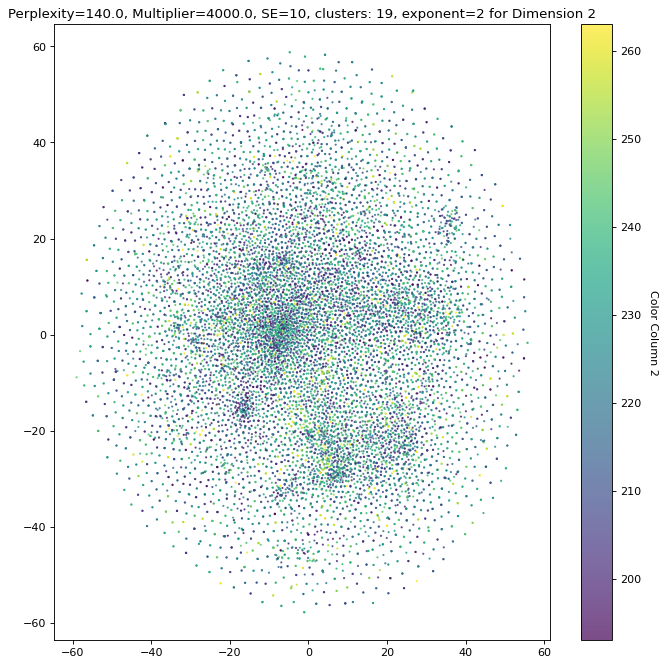

In [31]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
perplexity = n/100
#[30, 50, 100, n/100]
learning_rates = [n/12]
#[10,100,1000,n/12]
lr = n/12

plt.figure(figsize=(8,10), dpi=80)

# Apply t-SNE to combined data
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
embedded_points = tsne.fit_transform(combined_features)  # Run on combined data
# Create separate plots for each column in the color array
for i in range(cell_motor_coordinates_mice_subset.shape[1]):  # Loop through each column
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)

    # Normalize the colors
    norm = Normalize(vmin=np.min(cell_motor_coordinates_mice_subset[:, i]),
                     vmax=np.max(cell_motor_coordinates_mice_subset[:, i]))
    cmap = plt.cm.viridis  # Choose colormap

    # Scatter plot
    scatter = ax.scatter(
        embedded_points[:, 0],
        embedded_points[:, 1],
        c=cell_motor_coordinates_mice_subset[:, i],  # Use raw column values for coloring
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=1,
    )

    # Add colorbar and labels
    cbar = fig.colorbar(scatter, ax=ax)  # Explicitly associate colorbar with scatter plot
    cbar.set_label(f'Color Column {i}', rotation=270, labelpad=15)
    
    ax.set_title(f'Perplexity={perplexity}, Multiplier={multiplier}, SE={starting_epcoch}, clusters: {clusters}, exponent={exponent} for Dimension {i}')
    plt.show()

TSNE plot with cluster centers

[0 1 2 3]
Cluster 0: Mask shape = (14000,), Points = 3291
Cluster 1: Mask shape = (14000,), Points = 3056
Cluster 2: Mask shape = (14000,), Points = 3521
Cluster 3: Mask shape = (14000,), Points = 4132


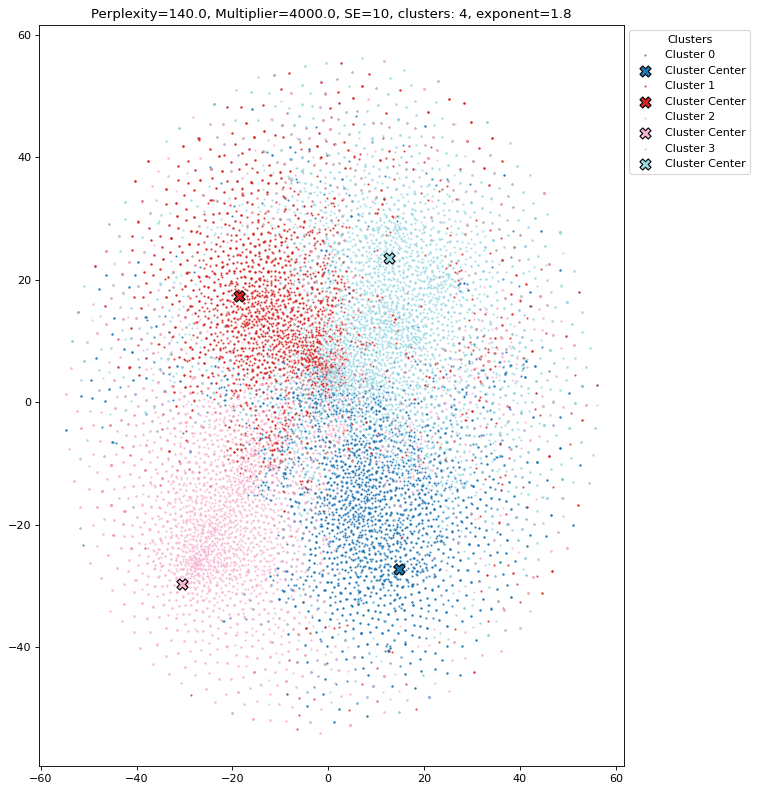

In [47]:
perplexity = n/100
#[30, 50, 100, n/100]
learning_rates = [n/12]
#[10,100,1000,n/12]
lr = n/12

plt.figure(figsize=(8,10), dpi=80)
print((unique_values))

colors = plt.cm.get_cmap("tab10", len(unique_values))  # Define colors for clusters

# Define colors explicitly
unique_values = np.unique(predictions_subset)
colors = plt.cm.get_cmap("tab20", len(unique_values))
color_map = {label: colors(i) for i, label in enumerate(unique_values)}

combined_data = np.vstack([combined_features, cluster_centers])  # Stack features with centers

# Apply t-SNE to combined data
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
embedded_data = tsne.fit_transform(combined_data)  # Run on combined data

# Split the result back into original points and cluster centers
n_samples = combined_features.shape[0]
embedded_points = embedded_data[:n_samples]  # First part corresponds to data points
embedded_centers = embedded_data[n_samples:]  # Last part corresponds to cluster centers

for value in unique_values:
    cluster_mask = predictions_subset == value
    print(f"Cluster {value}: Mask shape = {cluster_mask.shape}, Points = {cluster_mask.sum()}")
    
    plt.scatter(
        embedded_points[cluster_mask, 0],
        embedded_points[cluster_mask, 1],
        c=[color_map[value]],
        label=f'Cluster {value}',
        alpha=0.7,
        s=1,
    )
    plt.scatter(
        embedded_centers[value][0],
        embedded_centers[value][1],
        c=[color_map[value]],  # Mapped color
        marker='X',
        s=100,
        edgecolor='black',
        label='Cluster Center'
    )

plt.title(f'Perplexity={perplexity}, Multiplier={multiplier}, SE={starting_epcoch}, clusters: {clusters}, exponent={exponent}')

# Adjust layout for better spacing
plt.tight_layout()

# Add legend automatically from the scatter plot
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.savefig(f'plots/tsne_model_wo_rotation_{path_ending}.png', dpi=300, bbox_inches='tight')  # Save as PNG with hi
plt.show()

## Color by mice

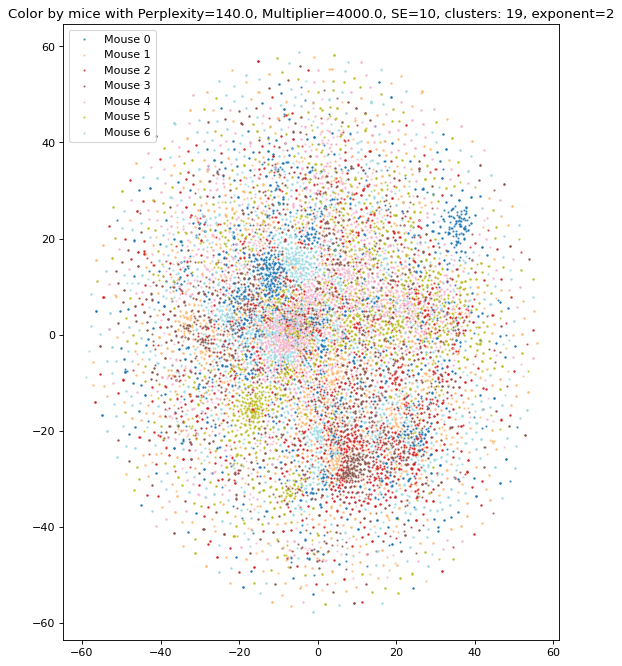

In [35]:
perplexity = n/100
lr = n/12

plt.figure(figsize=(8,10), dpi=80)

# Apply t-SNE to combined data
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
embedded_points = tsne.fit_transform(combined_features)  # Run on combined data

# Parameters
total_points = len(embedded_points)  # Total number of points
group_size = 2000  # Group size for each color
num_groups = total_points // group_size + (total_points % group_size > 0)  # Calculate number of groups

colors = plt.cm.get_cmap("tab20", num_groups)  # Dynamically create colormap
color_map = {group: colors(group) for group in range(num_groups)}
point_groups = np.arange(total_points) // group_size  # Assign each point a group

# Plot points with group colors
for group in range(num_groups):
    group_mask = point_groups == group

    plt.scatter(
        embedded_points[group_mask, 0],  # X coordinates of points in the group
        embedded_points[group_mask, 1],  # Y coordinates of points in the group
        c=[color_map[group]],  # Use color from the colormap
        label=f'Mouse {group}',
        alpha=0.7,  # Transparency
        s=1,  # Size of points
    )

plt.title(f'Color by mice with Perplexity={perplexity}, Multiplier={multiplier}, SE={starting_epcoch}, clusters: {clusters}, exponent={exponent}')
plt.legend()
plt.show()

In [ ]:
perplexity = n/100
#[30, 50, 100, n/100]
learning_rates = [n/12]
#[10,100,1000,n/12]
lr = n/12

plt.figure(figsize=(8,10), dpi=80)
print((unique_values))

total_labels = 14000
group_size = 2000
num_groups = total_labels // group_size

# Generate colors using tab20 colormap
colors = plt.cm.get_cmap("tab20", num_groups)  # Dynamically generate colors
color_map = {label: colors(label // group_size) for label in range(total_labels)}

combined_data = np.vstack([combined_features, cluster_centers])  # Stack features with centers

# Apply t-SNE to combined data
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
embedded_data = tsne.fit_transform(combined_data)  # Run on combined data

# Split the result back into original points and cluster centers
n_samples = combined_features.shape[0]
embedded_points = embedded_data[:n_samples]  # First part corresponds to data points
embedded_centers = embedded_data[n_samples:]  # Last part corresponds to cluster centers

for value in unique_values:
    cluster_mask = predictions_subset == value
    print(f"Cluster {value}: Mask shape = {cluster_mask.shape}, Points = {cluster_mask.sum()}")
    
    plt.scatter(
        embedded_points[cluster_mask, 0],
        embedded_points[cluster_mask, 1],
        c=[color_map[value]],
        label=f'Cluster {value}',
        alpha=0.7,
        s=1,
    )
    plt.scatter(
        embedded_centers[value][0],
        embedded_centers[value][1],
        c=[color_map[value]],  # Mapped color
        marker='X',
        s=100,
        edgecolor='black',
        label='Cluster Center'
    )

plt.title(f'Perplexity={perplexity}, Multiplier={multiplier}, SE={starting_epcoch}, clusters: {clusters}, exponent={exponent}')

# Adjust layout for better spacing
plt.tight_layout()

# Add legend automatically from the scatter plot
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.savefig(f'plots/tsne_model_wo_rotation_{path_ending}.png', dpi=300, bbox_inches='tight')  # Save as PNG with hi
plt.show()

Code for predictions

NameError: name 'dec_wamup_epcoh' is not defined

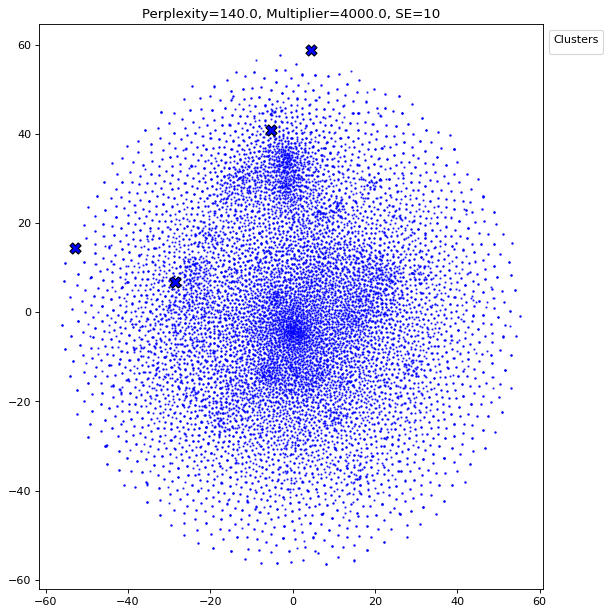

In [14]:
# Fixed Perplexity and Learning Rate
perplexity_values = [n / 100]
learning_rates = [n / 12]
lr = n / 12

# Set up the plot
plt.figure(figsize=(20, 15), dpi=80)

for i, perplexity in enumerate(perplexity_values):
    # Combine features and cluster centers for t-SNE
    combined_data = np.vstack([combined_features, cluster_centers])  # Stack features with centers
    
    # Apply t-SNE to combined data
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)
    embedded_data = tsne.fit_transform(combined_data)  # Run on combined data

    # Split the result back into original points and cluster centers
    n_samples = combined_features.shape[0]
    embedded_points = embedded_data[:n_samples]  # First part corresponds to data points
    embedded_centers = embedded_data[n_samples:]  # Last part corresponds to cluster centers

    # Create a subplot for each perplexity
    plt.subplot(2, 3, i + 1)  # Correct subplot indexing

    # Define a single color for all clusters
    single_color = 'blue'

    for label in unique_values:
        cluster_mask = predictions_subset == label  # Mask for the current cluster
        
        # Scatter plot for all points (same color)
        plt.scatter(
            embedded_points[cluster_mask, 0], embedded_points[cluster_mask, 1],
            c=single_color, alpha=0.7, s=1
        )
        # Plot cluster centers (same color, marked as X)
        plt.scatter(
            embedded_centers[label][0], embedded_centers[label][1], 
            c=single_color, marker='X', s=100, edgecolor='black'
        )

    
    plt.title(f'Perplexity={perplexity}, Multiplier={multiplier}, SE={starting_epcoch}')

# Adjust layout for better spacing
plt.tight_layout()

# Add legend automatically from the scatter plot
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.savefig(f'plots/tsne_model_wo_rotation_adaptlognorm_mult_{multiplier}se{starting_epcoch}_we{dec_wamup_epcoh}.png', dpi=300, bbox_inches='tight')  # Save as PNG with hi
plt.show()

Giff

In [ ]:
# Create a directory to store the individual heatmap frames
os.makedirs('heatmap_frames', exist_ok=True)

# Assuming cluster_centers_epochs is of shape (time, num_clusters, num_features)
time = cluster_centers_epochs.shape[0]
num_clusters = cluster_centers_epochs.shape[1]

# Loop to calculate distances and plot the heatmap for each epoch
for batch in range(time):
    # Step 1: Calculate the distance matrix for the current batch
    distance_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(cluster_centers_epochs[batch][i] - cluster_centers_epochs[batch][j])  # Euclidean distance

    # Step 2: Create a DataFrame to make it more interpretable
    distance_df = pd.DataFrame(distance_matrix, 
                               index=[f'Cluster {i}' for i in range(num_clusters)], 
                               columns=[f'Cluster {j}' for j in range(num_clusters)])

    # Step 3: Plot the distance table as a heatmap
    plt.figure(figsize=(10, 8), dpi=80)
    sns.heatmap(distance_df, annot=True, fmt=".2f", cmap="viridis", cbar=True)
    plt.title(f'Cluster Center Distances (Epoch {batch+1}/{time})')
    plt.xlabel('Cluster Number (j)')
    plt.ylabel('Cluster Number (i)')

    # Save each frame as an image
    frame_path = f'heatmap_frames/heatmap_epoch_{batch}.png'
    plt.savefig(frame_path, dpi=150, bbox_inches='tight')
    plt.close()  # Close the figure to free up memory

# Step 4: Create the GIF from saved frames
frames = []
for batch in range(time):
    frame_path = f'heatmap_frames/heatmap_epoch_{batch}.png'
    image = Image.open(frame_path)
    frames.append(image)

# Save the GIF
gif_path = 'plots/cluster_distance_heatmap.gif'
frames[0].save(
    gif_path, 
    save_all=True, 
    append_images=frames[1:], 
    duration=500,  # Duration of each frame in milliseconds
    loop=0  # Loop forever
)

print(f"GIF saved at {gif_path}")

TSNE plot without cluster centers

In [7]:
perplexity_values = 50
#[n/100]
#[30, 50, 100, n/100]
learning_rates = [n/12]
#[10,100,1000,n/12]
lr = n/12

# Create a plot for each perplexity value
plt.figure(figsize=(20, 20), dpi=80)

for i, perplexity in enumerate(perplexity_values):
    #for j, lr in enumerate(learning_rates):
        # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42)  # Adjust perplexity as needed
    embedded_data = tsne.fit_transform(combined_features)

    # Create a subplot for each perplexity
    plt.subplot(2,3, i + 1)  # Correct subplot indexing
    for label in unique_values:
        cluster_mask = predictions_subset == label  # Mask for the current cluster
        plt.scatter(
            embedded_data[cluster_mask, 0], embedded_data[cluster_mask, 1],
            c=[label_to_color[label]], label=f'Cluster {label}', alpha=0.7, s=1
        )
    plt.title(f'Perplexity={perplexity}')

# Adjust layout for better spacing
plt.tight_layout()

# Add legend automatically from the scatter plot
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.show()


TypeError: 'int' object is not iterable

<Figure size 1600x1600 with 0 Axes>

In [19]:
plt.savefig(f'plots/tsne_model_wo_rotation_adaptlognorm_mult_{multiplier}se{dec_starting_epcoch}_we{dec_wamup_epcoh}.png', dpi=300, bbox_inches='tight')  # Save as PNG with hi
plt.show()

<Figure size 640x480 with 0 Axes>